# Predict an ONNX InferenceService

This example assumes you have already deployed the sample ONNX Inference Service. 

Deploy the sample ONNX InferenceSevice by following the instructions in the [README](https://github.com/kserve/kserve/blob/master/docs/samples/v1beta1/onnx/README.md)

In [1]:
%%bash
echo "service url: $SERVICE_HOSTNAME"
echo "ingress ip: $INGRESS_HOST"
echo "ingress port: $INGRESS_PORT"

model name: style-sample
service url: style-sample.default.example.com
cluster ip: 52.247.193.219


In [4]:
# if you dont see values above, see instructions in the readme and replace the values here!
import os
model_name = "default"
service_hostname = os.environ["SERVICE_HOSTNAME"]
ingress_ip = os.environ["INGRESS_HOST"]
ingress_port = os.environ["INGRESS_PORT"]
predictor_url = "http://%s:%s/v1/models/default:predict" % (ingress_ip, ingress_port)
predictor_url

'http://52.247.193.219/v1/models/style-sample:predict'

In [5]:
from PIL import Image
import numpy as np
import google.protobuf.json_format as json_format
import assets.onnx_ml_pb2 as onnx_ml_pb2
import assets.predict_pb2 as predict_pb2
import requests

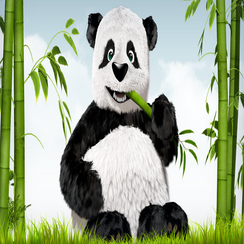

In [6]:
# load & resize image
image = Image.open("image.jpg")
image = image.resize((224,224), Image.ANTIALIAS)
image

In [7]:
# preprocess image data
norm_img_data = np.array(image).astype('float32')
norm_img_data = np.transpose(norm_img_data, [2, 0, 1])
norm_img_data = np.expand_dims(norm_img_data, axis=0)
np.shape(norm_img_data)

(1, 3, 244, 244)

In [8]:
# Create request message to be sent to the predictor
input_tensor = onnx_ml_pb2.TensorProto()
input_tensor.dims.extend(norm_img_data.shape)
input_tensor.data_type = 1
input_tensor.raw_data = norm_img_data.tobytes()

request_message = predict_pb2.PredictRequest()
request_message.inputs["input1"].data_type = input_tensor.data_type
request_message.inputs["input1"].dims.extend(input_tensor.dims)
request_message.inputs["input1"].raw_data = input_tensor.raw_data

# write message data to JSON
message_data = json_format.MessageToJson(request_message)

In [9]:
# Call predictor
request_headers = {'Content-Type': 'application/json', 'Accept': 'application/json', 'Host': service_hostname}
response = requests.post(predictor_url, headers=request_headers, data=message_data)

In [10]:
# Parse response message
response_message = json_format.Parse(response.text, predict_pb2.PredictResponse())
output1 = np.frombuffer(response_message.outputs['output1'].raw_data, dtype=np.float32)
output1 = output1.reshape(3,224,224)

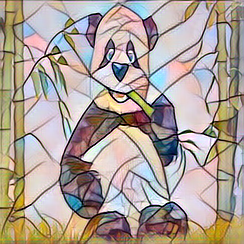

In [11]:
# postprocess
result = np.clip(output1, 0, 255)
result = result.transpose(1,2,0).astype("uint8")
img = Image.fromarray(result)
img